# MODIS time series and global distributions

TIWP is available in MODIS as L3 daily means. Only cloudy pixels are used in the aggregation, so the L3 IWP needs to be multiplied by ice cloud fraction to obtain the TIWP across the entire pixel. Fractions in the `Cloud_Retrieval_Fraction_Ice` data are the fraction of daytime-only pixels within a L3 grid box that have successful MOD06 cloud optical property retrievals and were classified as ice cloud. Water path values are derived using visible channels, so TIWP is only available for daytime.

Fractions in the `Cloud_Fraction` data are daily means of the fraction of pixels for a given population within a L3 grid box that are determined to be cloudy or probably cloudy by the MOD35 cloud mask. By population, it is meant that separate data exists for daytime-only, nighttime-only, and daytime+nighttime.

Details on the data, including ATBD, file specification, and user guide can be found at:
https://atmosphere-imager.gsfc.nasa.gov/products/daily

## Notes on averaging

**<ins>Mean of means</ins>**

As mentioned, the MODIS data used here are L3 daily means. Generally, if you want to calculate a mean of means, then you weight by the number of datapoints that went into each mean.

**Something important to note about MODIS data: Cloud optical properties are produced only for pixels identified as probably cloudy or cloudy by the cloud mask. In other words, it only performs a retrieval of IWP when there is a cloud. So this is a count of cloudy cases, NOT observations. There are no cases of IWP=0 in the L3 data.**

A weighted mean of means assumes the same statistics over the time-period. This is likely valid over a single month for MODIS data, since the number of clouds on each day will be similar. MODIS documentation says that you should do this weighting when calculating the mean of a single 1$^{\circ}$ x 1$^{\circ}$ grid box, and does so for their L3 monthly mean product.

The assumption of the same statistics over a time period is likely not valid over a full year, or longer.
Likewise, the assumption does not hold when we want to average over longitude (in the case of zonal means), or over both latitude and longitude (in the case of global means).
Over a month, the statistics are fairly constant. However, I have calculated non-weighted means for all statistics, so that results are consistent (since weighting can give quite different results).

**<ins>Use of xarray methods</ins>**

Manually computing statistics will give a different result to those computed using xarray.<br>
For an example, see the zonal means in the section 'Zonal mean averaging methods' below.<br>
Why does this happen? The reason for this can be understood by looking at the zonal distribution of the counts (also below).
As a reminder, this is the mean count of cloudy cases, not observations. Therefore, the number of retrievals per latitude will vary. If using xarray to get the mean, it will account for this variation in its calculation and weight accordingly. (If my understanding of xarray is correct). This essentially results in a zonal mean that unfairly 'ignores clear-sky'.

In contrast, by manually computing the zonal mean, we can assume that all longitudes and all days hold an equal weight towards the zonal mean, which is more realistic.

Alternatively, we can still use xarray, but account for the fact that some IWP=NaN cases correspond to IWP=0. Areas with no observations (or failed downloads) will also be NaN in the ice cloud fraction data. So we set all nan IWP to zero, and then multiply with ice cloud fraction to mask out any of the 'true' NaN cases. This is the best way to do it, as it is a little more accurate near the poles where there is not data every day of the year.

**<ins>Differences to Duncan et al. (2018)</ins>**

Duncan et al. (2018) also computed global distributions and zonal means of TIWP, for the year 2015.
The zonal mean is taken as the average over 365 days. The 'manual'/'xarray 2' zonal mean for 2015 calculated in this notebook (below) matches Fig. 3 in Duncan et al.

The global distribution (i.e. means for lat-lon grid cells) for 2015 calculated in this notebook does not match Duncan et al. The reason can be seen in the plots in section 'Global distribution averaging methods' below, where the mean is taken several different ways.
- The first method is to sum the data for a year, and divide by 365 days.
- The second method is to divide by the number of non-NaN ice cloud fraction data points. This is equivalent to the number of days that a grid cell contained ice clouds. This includes cases that are zero. 
- The third method is to divide by the number of non-NaN IWP data points. This is equivalent to the number of days with IWP retrievals. This does not include cases that are zero. 

Duncan et al. uses the third method (note that panel (c) is the same as Fig. 1 in Duncan et al.). However, again, a valid IWP retrieval only occurs when there is cloud, and does not include zero values. So I have instead chosen to average over the number of valid ice cloud fraction data points, since this data includes zero values. In general, this gives a lower IWP for many grid cells compared to Duncan et al.

In [5]:
import os
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import cmocean as cmo
import geopandas as gpd
from matplotlib.colors import LogNorm

In [6]:
#import jupyter_black

#jupyter_black.load()

In [7]:
plt.style.use("../ccic.mplstyle")

# Zonal mean averaging methods

In [8]:
file_path = "/scratch/ccic_record/data/modis/ccic_modis_data_2015.nc"
dataset = xr.open_dataset(file_path)

IWP = dataset.Cloud_Water_Path_Ice_Mean
IWP = IWP.where(IWP >= 0)
CF_ice = dataset.Cloud_Retrieval_Fraction_Ice
CF_ice = CF_ice.where(CF_ice >= 0) * 0.0001
TIWP = IWP * CF_ice

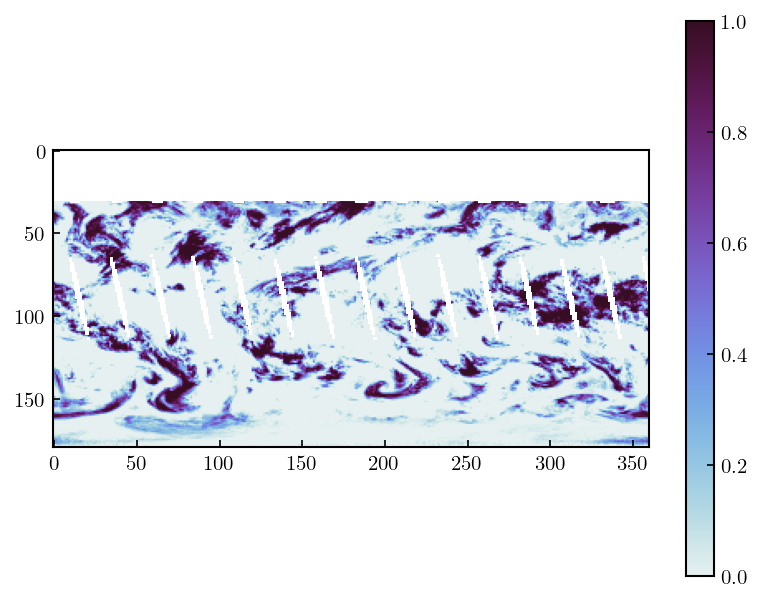

In [11]:
plt.imshow(CF_ice[0])
plt.colorbar()

In [5]:
# Method of manually calculating the zonal mean (equal longitude weighting)
TIWP_zonal_mean_manual = np.zeros(180)
TIWP_zonal_count = np.zeros(180)

for i in range(IWP.shape[0]):
    TIWP_zonal_mean_manual += np.nansum(TIWP[i].values, axis=1)
    TIWP_zonal_count += 1 * 360  # +1 for every day and 360 for longitudes

TIWP_zonal_mean_manual /= TIWP_zonal_count

# Using xarray to calculate the zonal mean
TIWP_zonal_mean_xarray = TIWP.mean(("lon", "date"))

valid_data_count = TIWP.count(dim=["lon", "date"])

# alternative xarray method - setting nan IWP to 0, instead using CF_ice nan values to indicate missing data
IWP_method2 = IWP.where(IWP >= 0).fillna(0)
TIWP_method2 = IWP_method2 * CF_ice
TIWP_zonal_mean_method2 = TIWP_method2.mean(("lon", "date"))

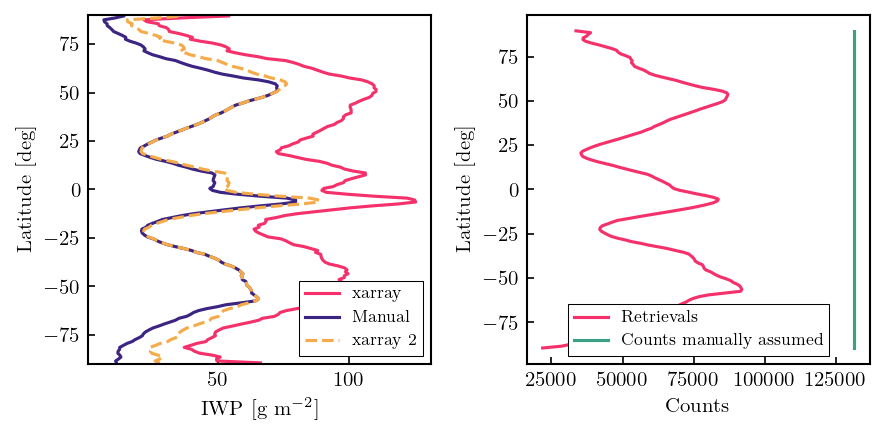

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.plot(TIWP_zonal_mean_xarray.values, dataset.lat.values, label="xarray")
ax1.plot(TIWP_zonal_mean_manual, dataset.lat.values, color="C2", ls="-", label="Manual")
ax1.plot(
    TIWP_zonal_mean_method2, dataset.lat.values, color="C3", ls="--", label="xarray 2"
)
ax1.set_xlabel(r"IWP [g m$^{-2}$]")
ax1.set_ylabel(r"Latitude [deg]")
ax1.set_ylim([-90, 90])

ax1.legend(fontsize=8)

ax2.plot(valid_data_count, dataset.lat.values, label="Retrievals")
ax2.plot(TIWP_zonal_count, dataset.lat.values, label="Counts manually assumed")
ax2.set_xlabel("Counts")
ax2.set_ylabel(r"Latitude [deg]")
ax2.legend(fontsize=8)

fig.tight_layout()

# Global distribution averaging methods

In [7]:
total_zero_count_IWP = IWP.where(IWP == 0).count().item()
print(f"Number of zero IWP cases: {total_zero_count_IWP}")
total_zero_count_CF_ice = CF_ice.where(CF_ice == 0).count().item()
print(f"Number of zero CF_ice cases: {total_zero_count_CF_ice}")

Number of zero IWP cases: 0
Number of zero CF_ice cases: 8815340


In [8]:
TIWP_global_dist_2018_method1 = np.nansum(IWP * CF_ice, axis=0) / 365

TIWP_global_dist_2018_method2 = np.nansum(IWP * CF_ice, axis=0) / np.sum(
    ~np.isnan(CF_ice), axis=0
)

TIWP_global_dist_2018_method3 = np.nansum(IWP * CF_ice, axis=0) / np.sum(
    ~np.isnan(IWP), axis=0
)

/tmp/ipykernel_1905763/197304152.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


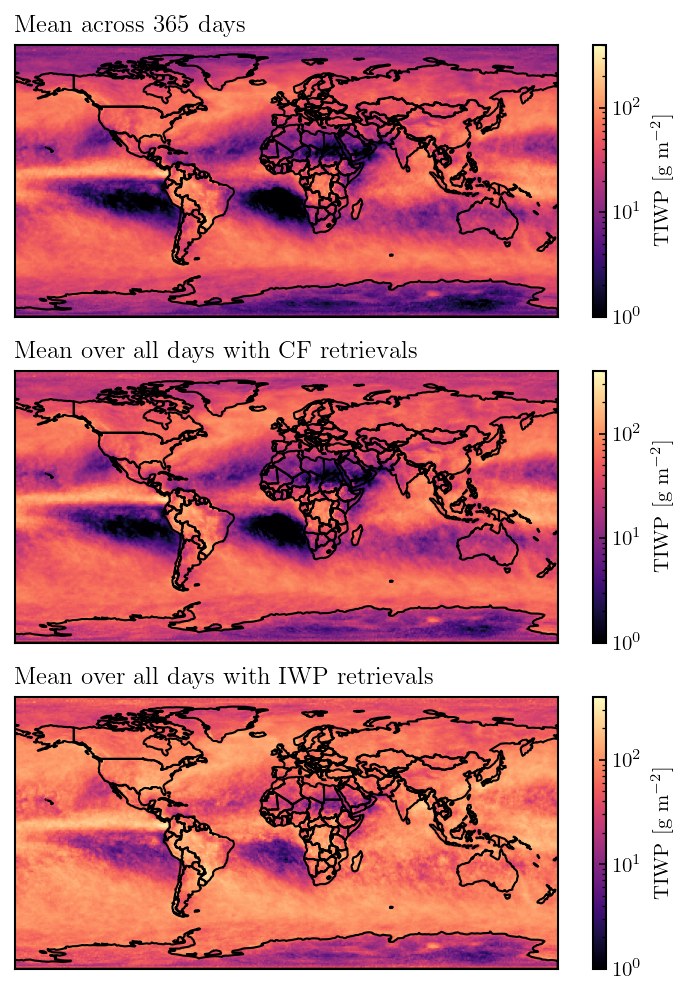

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

extent = [
    CF_ice.lon[0] - 0.5,
    CF_ice.lon[-1] + 0.5,
    CF_ice.lat[0] - 0.5,
    CF_ice.lat[-1] + 0.5,
]

im1 = ax1.imshow(
    TIWP_global_dist_2018_method1,
    norm=LogNorm(vmin=1e0, vmax=4e2),
    cmap="magma",
    extent=extent,
)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Mean across 365 days", loc="left")
world.boundary.plot(ax=ax1, color="black", lw=1)

im2 = ax2.imshow(
    TIWP_global_dist_2018_method2,
    norm=LogNorm(vmin=1e0, vmax=4e2),
    cmap="magma",
    extent=extent,
)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Mean over all days with CF retrievals", loc="left")
world.boundary.plot(ax=ax2, color="black", lw=1)

im3 = ax3.imshow(
    TIWP_global_dist_2018_method3,
    norm=LogNorm(vmin=1e0, vmax=4e2),
    cmap="magma",
    extent=extent,
)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Mean over all days with IWP retrievals", loc="left")
world.boundary.plot(ax=ax3, color="black", lw=1)

cb1 = fig.colorbar(im1)
cb1.set_label(r"TIWP [g m$^{-2}$]")

cb2 = fig.colorbar(im2)
cb2.set_label(r"TIWP [g m$^{-2}$]")

cb3 = fig.colorbar(im3)
cb3.set_label(r"TIWP [g m$^{-2}$]")

# Interpolation/masking

Just a sanity check to see if all looks okay for a single day of data. Actual interpolation and masking is done as pre-processing step.

In [10]:
file_path = "/scratch/ccic_record/data/modis/ccic_modis_data_2022.nc"
dataset = xr.open_dataset(file_path)

mask = xr.open_dataset("../mask_24_for_modis.nc")
mask = mask.mask == 1

In [11]:
# Extract cloud fraction, remove any invalid data, and apply the masj
latitude = dataset["lat"][:]
longitude = dataset["lon"][:]
data = dataset["Cloud_Fraction_Mean"][220, :, :].values
data_filtered = np.where((data == -9999) | (data == -2147483647), np.nan, data)
data_filtered = data_filtered.astype(float) * 0.0001

mask_24 = xr.open_dataset("/scratch/ccic_record/data/mask_24.nc")

data_masked = dataset["Cloud_Fraction_Mean"].where(mask == 1)[220, :, :].values
data_filtered_masked = np.where(
    (data_masked == -9999) | (data_masked < -0), np.nan, data_masked
)
data_filtered_masked = data_filtered_masked.astype(float) * 0.0001

/tmp/ipykernel_1905763/344799901.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


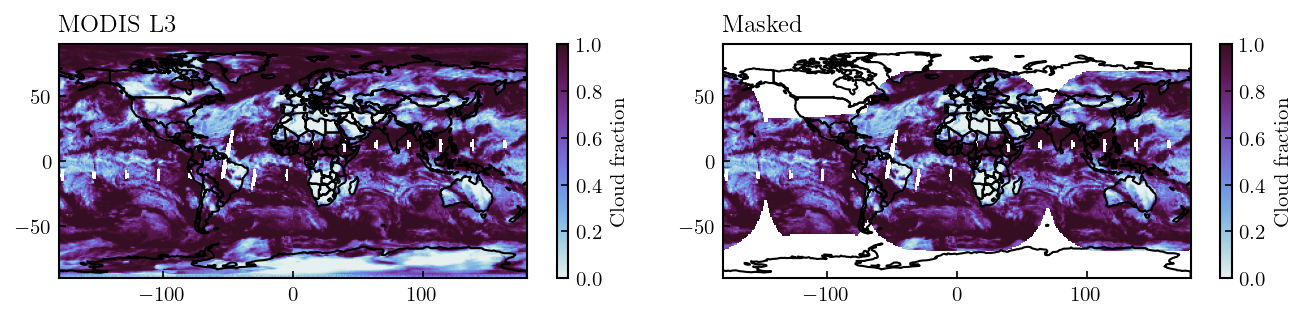

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9, 2))

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

extent = [
    longitude[0] - 0.5,
    longitude[-1] + 0.5,
    latitude[0] - 0.5,
    latitude[-1] + 0.5,
]

cax = axes[0].imshow(data_filtered, extent=extent)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction")
world.boundary.plot(ax=axes[0], color="black", lw=1)
axes[0].set_title(r"MODIS L3")

cax2 = axes[1].imshow(
    data_filtered_masked,
    extent=extent,
)
world.boundary.plot(ax=axes[1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"Cloud fraction")
axes[1].set_title(r"Masked")

fig.tight_layout()

# Time series

A note on MODIS monthly means: MODIS only retrives on sunlit (daytime) pixels. This means that there is no data at very high latitudes during the northern hemisphere winter, and vice versa for the southern hemisphere. It's therefore not entirely fair to compare e.g. January and April, since different latitudes are averaged over.

This is only really relevant for the 'unmasked' data, since we mask out high latitudes in the 'masked' data-

In [13]:
time_series = xr.open_dataset(
    "/scratch/ccic_record/data/processed/modis_cf_tiwp_time_series.nc"
)

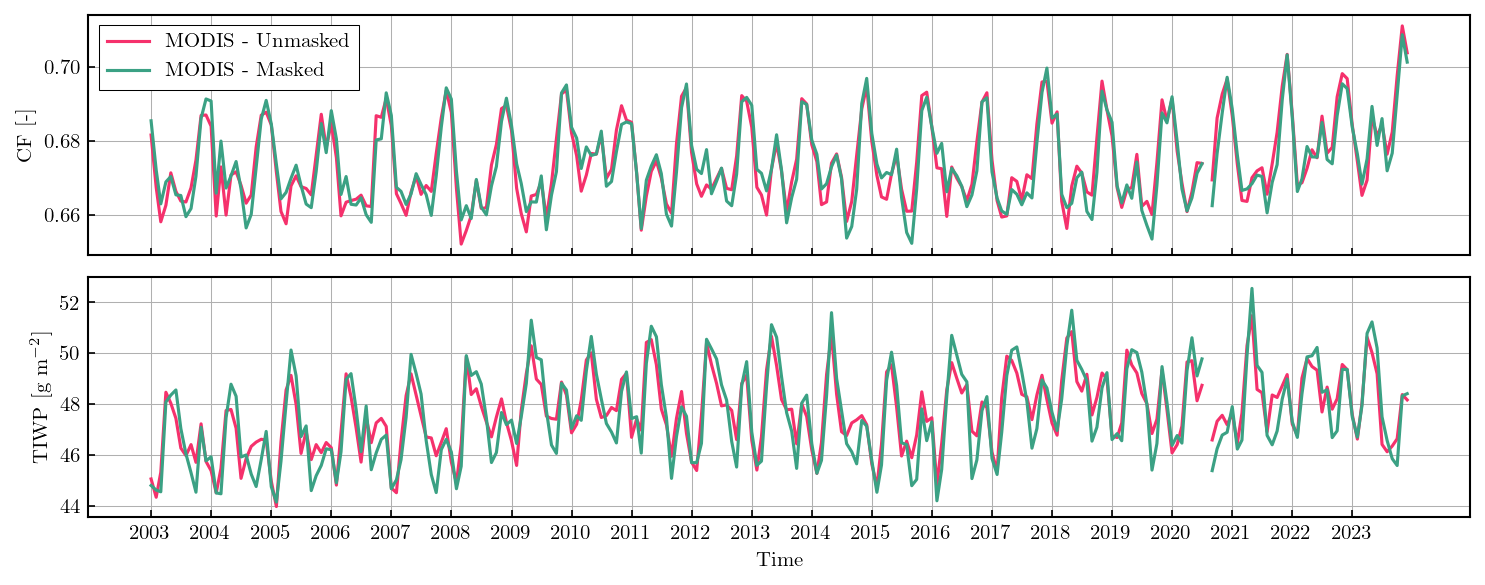

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))

ax1.plot(
    time_series["date"],
    time_series["CF_global_mean_unmasked"].values,
    label="MODIS - Unmasked",
)
ax1.plot(
    time_series["date"],
    time_series["CF_global_mean_masked"].values,
    label="MODIS - Masked",
)

ax2.plot(
    time_series["date"],
    time_series["TIWP_global_mean_unmasked"].values,
    label="MODIS - Unmasked",
)
ax2.plot(
    time_series["date"],
    time_series["TIWP_global_mean_masked"].values,
    label="MODIS - Masked",
)

# ax.set_ylim([0.63, 0.715])
ax1.set_xticks(time_series["date"][::12])
ax2.set_xticks(time_series["date"][::12])
ax1.set_xticklabels([])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2.set_xlabel("Time")

ax1.set_ylabel("CF [-]")
ax2.set_ylabel(r"TIWP [g m$^{-2}$]")

ax1.legend()

ax1.grid()
ax2.grid()

fig.tight_layout()

# plt.savefig(f'cf_tiwp_timeseries_modis.pdf', facecolor='white', bbox_inches="tight")

# Global distributions

In [15]:
global_distribution = xr.open_dataset("/scratch/ccic_record/data/processed/modis_global_distribution_cf_tiwp.nc")

/tmp/ipykernel_1905763/1337505317.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


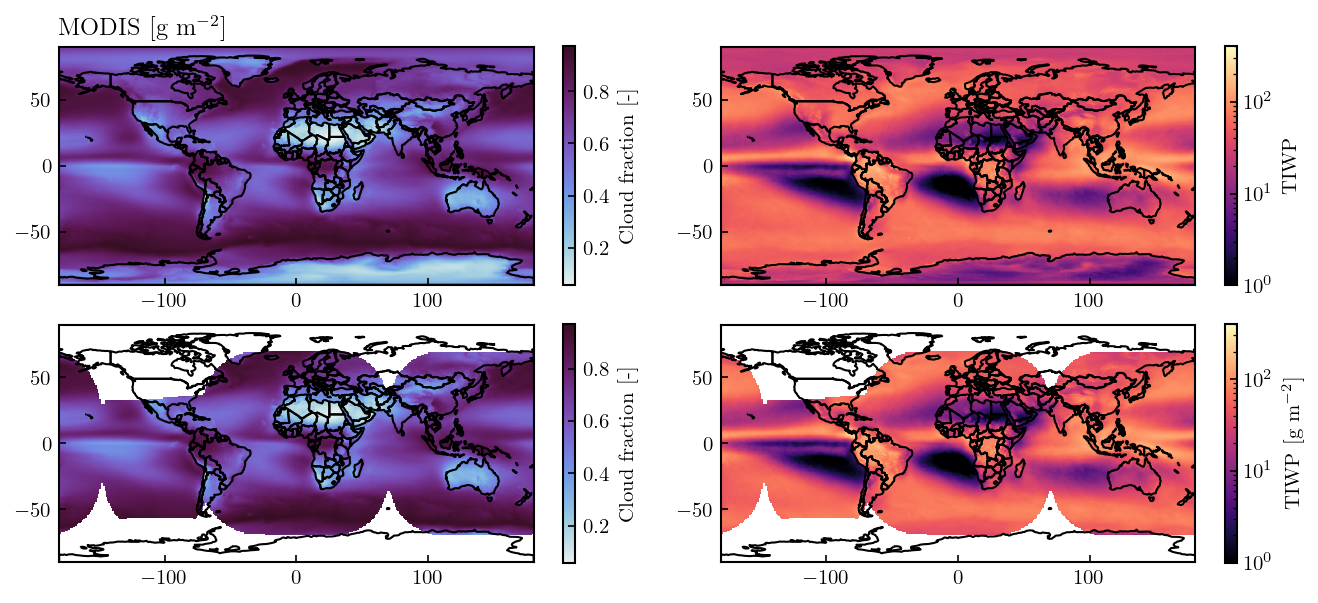

In [16]:
latitude = global_distribution["lat"][:]
longitude = global_distribution["lon"][:]

fig, axes = plt.subplots(2, 2, figsize=(9, 4))

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

extent = [
    longitude[0] - 0.5,
    longitude[-1] + 0.5,
    latitude[0] - 0.5,
    latitude[-1] + 0.5,
]

cax = axes[0, 0].imshow(
    global_distribution["CF_global_distribution_unmasked"], extent=extent
)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction [-]")
world.boundary.plot(ax=axes[0, 0], color="black", lw=1)
axes[0, 0].set_title(r"MODIS [g m$^{-2}$]")

cax2 = axes[0, 1].imshow(
    global_distribution["TIWP_global_distribution_unmasked"],
    extent=extent,
    norm=LogNorm(vmin=(1e0), vmax=4e2),
    cmap="magma",
)
world.boundary.plot(ax=axes[0, 1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"TIWP")

cax = axes[1, 0].imshow(
    global_distribution["CF_global_distribution_masked"], extent=extent
)
cbar = fig.colorbar(cax)
cbar.set_label(r"Cloud fraction [-]")
world.boundary.plot(ax=axes[1, 0], color="black", lw=1)

cax2 = axes[1, 1].imshow(
    global_distribution["TIWP_global_distribution_masked"],
    extent=extent,
    norm=LogNorm(vmin=(1e0), vmax=4e2),
    cmap="magma",
)
world.boundary.plot(ax=axes[1, 1], color="black", lw=1)
cbar2 = fig.colorbar(cax2)
cbar2.set_label(r"TIWP [g m$^{-2}$]")

fig.tight_layout()

# Zonal mean

In [17]:
zonal_mean = xr.open_dataset("/scratch/ccic_record/data/processed/modis_zonal_mean_cf_tiwp.nc")
latitude = zonal_mean["lat"][:]

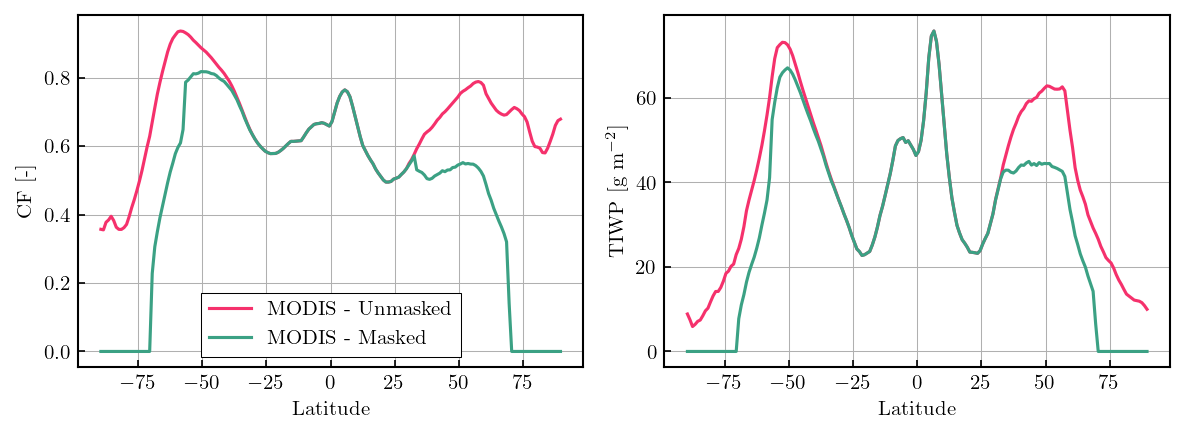

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(
    latitude, zonal_mean["CF_zonal_mean_unmasked"].values, label="MODIS - Unmasked"
)
ax1.plot(latitude, zonal_mean["CF_zonal_mean_masked"].values, label="MODIS - Masked")

ax2.plot(
    latitude, zonal_mean["TIWP_zonal_mean_unmasked"].values, label="MODIS - Unmasked"
)
ax2.plot(latitude, zonal_mean["TIWP_zonal_mean_masked"].values, label="MODIS - Masked")

ax1.set_xlabel("Latitude")
ax2.set_xlabel("Latitude")

ax1.set_ylabel("CF [-]")
ax2.set_ylabel(r"TIWP [g m$^{-2}$]")

ax1.legend()

ax1.grid()
ax2.grid()

fig.tight_layout()

# plt.savefig(f'cf_tiwp_zonal_mean_modis.pdf', facecolor='white', bbox_inches="tight")